# Check for gaps and tidally filter upper antioch (anh upper) data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, correlate, correlation_lags, find_peaks_cwt
from scipy.integrate import trapz
from datetime import datetime, timedelta
from vtools.functions.filter import cosine_lanczos
from vtools.data.vtime import days, hours, minutes
from sklearn.linear_model import LinearRegression

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# functions to filter and gapfill

In [2]:
#function comes from schimpy metricsplot.py script https://github.com/CADWRDeltaModeling/schimpy/blob/master/schimpy/metricsplot.py
def filter_timeseries(tss, cutoff_period=hours(40)):
    """ Filter time series

        Parameters
        ----------

        Returns
        -------
        list of vtools.data.timeseries.TimeSeries
            filtered time series
    """

    filtered = []
    ts=tss #try removing the loop for now
    if ts is None:
        filtered.append(None)
    else:
        #print(ts)
        ts_filtered = cosine_lanczos(ts, cutoff_period=cutoff_period)
        ts_filtered.filtered = 'cosine_lanczos'
        #ts_filtered.unit = ts.unit
        #filtered.append(ts_filtered)
    # for ts in tss:
    #     if ts is None:
    #         filtered.append(None)
    #     else:
    #         print(ts)
    #         ts_filtered = cosine_lanczos(ts, cutoff_period=cutoff_period)
    #         ts_filtered.filtered = 'cosine_lanczos'
    #         ts_filtered.unit = ts.unit
    #         filtered.append(ts_filtered)
    return ts_filtered

In [3]:
def find_gaps(sjj_dms,gapmin,gapmax=np.nan):
    #where sjj is a salinity pandas df with a time index and gapmin is type pd.Timedelta minimum gap length
    #and the output is the good index before and the good index after the gap
    freq=sjj_dms.index[1]-sjj_dms.index[0]
    sjj_dropna=sjj_dms.dropna()
    sjj_dropna['date_col']=np.array([d.to_datetime64() for d in sjj_dropna.index])
    sjj_dropna['gap']=sjj_dropna.date_col.diff()
    #gapmin1=pd.Timedelta('16 min')
    if pd.isnull(gapmax):
        mask=sjj_dropna.date_col.diff().gt(gapmin)
    else:
        mask1=sjj_dropna.date_col.diff().lt(gapmax)
        mask2=sjj_dropna.date_col.diff().gt(gapmin)
        mask=mask1*mask2 # if true in both cases, will be true in the product
    # get values
    starts = sjj_dropna.loc[mask.shift(-1, fill_value=False), 'date_col'].add(freq).astype(str)
    stops = sjj_dropna.loc[mask, 'date_col'].sub(freq).astype(str)
    # build output
    out = list(zip(starts, stops))
    return out


# load data

In [4]:
dtformat = '%Y-%m-%dT%H:%M:%S'
anh_dms=pd.read_csv('/global/scratch/users/jennaisrael/time_varying_data/dmsdatastore/salinity/dms_anh_upper.csv')
anh_dms=anh_dms.rename(columns={"screened/anh/upper/dwr_des/50/ec/microS/cm": "Salinity[mS/cm]"})
anh_dms['datetime']=pd.to_datetime(anh_dms['datetime'],format=dtformat)
anh_dms.set_index("datetime",inplace=True)
anh_dms=anh_dms.asfreq('15min')
#anh_dms_filt=filter_timeseries(anh_dms)


In [5]:
anh_dms

,Salinity[mS/cm]
datetime,
2012-01-06 23:15:00,1960.0
2012-01-06 23:30:00,2001.0
2012-01-06 23:45:00,1931.0
2012-01-07 00:00:00,1870.0
2012-01-07 00:15:00,1923.0
...,...
2026-01-13 23:15:00,203.0
2026-01-13 23:30:00,203.0
2026-01-13 23:45:00,198.0


# identify gaps

In [6]:
# fill the gaps smaller than 2 hrs using linear interpolation
gapmin=pd.Timedelta('16 min')
gapmax=pd.Timedelta('121 min')
anh_smallgaps=find_gaps(anh_dms,gapmin,gapmax)
#hol2_smallgaps=find_gaps(hol2_dms,gapmin,gapmax)

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [7]:
#iterate through the gaps
anh_sm_filled=anh_dms.copy()
for g in anh_smallgaps:
    #to linearly interpolate we need the values on the other side
    start=pd.to_datetime(g[0])-pd.Timedelta('15min')
    end=pd.to_datetime(g[1])+pd.Timedelta('15min')
    dates2fill=pd.date_range(start,end,freq='15min')
    num2fill=len(dates2fill)
    # if start == end:
    #     dates2fill=start
    #     num2fill=1
    # else:
    #     flag=1
    #     dates2fill=pd.date_range(start,end,freq='15min')
    #     num2fill=len(dates2fill)
    #make sure they are all nans
    if np.sum(np.isnan(anh_sm_filled.loc[dates2fill]['Salinity[mS/cm]']))==num2fill-2:
        print('gap is all nans')
        anh_sm_filled['Salinity[mS/cm]'].loc[dates2fill]= anh_dms['Salinity[mS/cm]'].loc[dates2fill].interpolate() #needs to be a 1D array #needs to be a 1D array
        if np.sum(np.isnan(anh_sm_filled.loc[dates2fill]['Salinity[mS/cm]']))== 0:
            print('gap has been filled!')
    else:
        print('Not all nans! Check ' + g[0] +' to '+g[1])   

gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
g

In [8]:
anh_check=find_gaps(anh_sm_filled,gapmin,gapmax)
anh_check

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


[]

In [9]:
gapmin=pd.Timedelta('122min')
anh_large=find_gaps(anh_dms,gapmin)
anh_large

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


[('2012-11-15 09:45:00', '2012-11-15 13:15:00'),
 ('2013-11-29 10:30:00', '2013-12-01 15:00:00'),
 ('2014-07-04 02:30:00', '2014-07-07 12:30:00'),
 ('2014-08-09 06:45:00', '2014-08-09 08:30:00'),
 ('2014-08-09 20:00:00', '2014-08-11 07:30:00'),
 ('2016-05-10 12:15:00', '2016-05-11 07:30:00'),
 ('2017-07-19 11:30:00', '2017-07-19 14:45:00'),
 ('2017-07-19 21:15:00', '2017-07-20 04:15:00'),
 ('2019-06-05 08:45:00', '2019-06-05 12:30:00'),
 ('2020-01-08 17:00:00', '2020-01-08 23:45:00'),
 ('2020-08-29 18:30:00', '2020-08-30 05:00:00'),
 ('2021-01-01 17:45:00', '2021-01-01 19:45:00'),
 ('2021-08-30 09:15:00', '2021-09-07 09:45:00'),
 ('2022-09-28 05:45:00', '2022-09-28 11:30:00'),
 ('2023-03-02 11:45:00', '2023-03-03 12:00:00'),
 ('2024-12-05 10:15:00', '2024-12-06 15:45:00')]

# Looks like Anh lower has some of the same gaps, maybe hold off on gapfilling everything for now since we're just using this to compute a proxy for the salinity gradient

In [10]:
anh_dms_filt=filter_timeseries(anh_sm_filled)


<AxesSubplot:xlabel='datetime'>

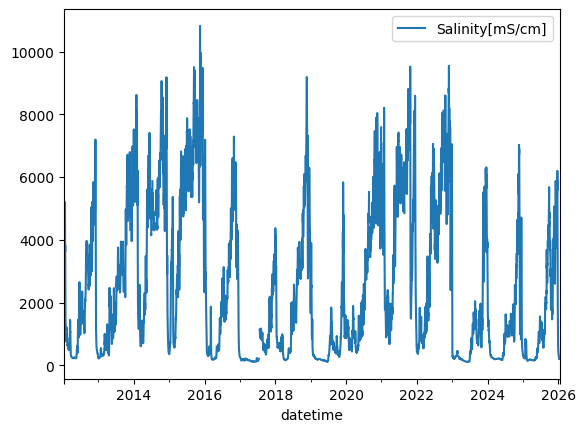

In [11]:
anh_dms_filt.plot()

In [13]:
# anh_dms_filt.rename(columns={'Salinity[mS/cm]':'Salinity[microS/cm]'}).to_csv('/global/scratch/users/jennaisrael/time_varying_data/dmsdatastore/salinity/anh_sm_gapfilled_filt_2026_01_16.csv')
